In [ ]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from unittest import TestCase
import os

# In order to execute this script, it is necessary to
# set the environment variable engine as "pytorch" before initializing
# simulai
os.environ['engine'] = 'pytorch'

from simulai.utilities.lorenz_solver import lorenz_solver_forcing
from simulai.regression import DenseNetwork
from simulai.models import DeepONet
from simulai.optimization import Optimizer
from simulai.metrics import L2Norm

This is an application in which we are interestiong in using a DeepONet for apporximating the following problem:
$$
    \frac{d\mathbf{u}}{dt} = \mathcal{F}(\mathbf{u}, \mathbf{v})
$$
In which $\mathcal{F}$ is a DeepONet operator, $\mathbf{u}$ is the field variables array and $\mathbf{v}$ is the forcing variables array. It is not the more tradicional application for this methodology.

Problem parameters.

In [2]:
dt = 0.0025
T_max = 50
rho = 28
beta = 8 / 3
beta_str = '8/3'
sigma = 10
A = 1
n_steps = int(T_max / dt)
forcings_file = 'forcings.npy'

Forcing terms generation (in this example they are randomly created).

In [3]:
if not os.path.isfile(forcings_file):
    forcings = A * np.random.rand(n_steps, 3)
    np.save('forcings.npy', forcings)
else:
    forcings = np.load('forcings.npy')

Generating datasets.

In [4]:
initial_state = np.array([1, 2, 3])[None, :]
lorenz_data, derivative_lorenz_data = lorenz_solver_forcing(rho=rho, dt=dt, T=T_max, sigma=sigma,
                                                            initial_state=initial_state, forcing=forcings,
                                                            beta=beta, beta_str=beta_str,
                                                            data_path='on_memory', solver='RK45')

Iteration 19661

The fraction of data used for training the model.

In [5]:
train_fraction = 0.8

Defining datasets.

In [6]:
input_data = lorenz_data
output_data = derivative_lorenz_data

Auxiliary variables and parameters.

In [7]:
n_samples = input_data.shape[0]
train_samples = int(train_fraction*n_samples)
test_samples = n_samples - train_samples

input_labels = ['x', 'y', 'z']
output_labels = ['x_dot', 'y_dot', 'z_dot']

time = np.arange(0, n_samples, 1)*dt

n_inputs = len(input_labels)
n_outputs = len(output_labels)

Training dataset

In [8]:
train_field_data = input_data[:train_samples]
train_forcing_data = forcings[:train_samples]
train_output_data = output_data[:train_samples]
time_train = time[:train_samples]

Testing dataset.

In [9]:
test_input_data = input_data[train_samples:]
test_forcing_data = forcings[train_samples:]
test_output_data = output_data[train_samples:]
time_test = time[train_samples:]

Neural network parameters.

In [10]:
lambda_1 = 1e-5  # Penalty for the L¹ regularization (Lasso)
lambda_2 = 1e-5  # Penalty factor for the L² regularization
n_epochs = int(3e3)  # Maximum number of iterations for ADAM
lr = 1e-3  # Initial learning rate for the ADAM algorithm
n_latent = 50

Configuration for the fully-connected trunk network

In [11]:
trunk_config = {
                'layers_units': [50, 50, 50],  # Hidden layers
                'activations': 'elu',
                'input_size': n_inputs,
                'output_size': n_latent*n_outputs,
                'name': 'trunk_net'
               }

Configuration for the fully-connected branch network.

In [12]:
branch_config = {
                'layers_units': [50, 50, 50],  # Hidden layers
                'activations': 'elu',
                'input_size': n_inputs,
                'output_size': n_latent*n_outputs,
                'name': 'branch_net'
                }

Instantiating trunk and branch networks.

In [13]:
trunk_net = DenseNetwork(**trunk_config)
branch_net = DenseNetwork(**branch_config)

trunk_net.summary()
branch_net.summary()

Summary of the network properties:
Linear operations layers:

[Linear(in_features=3, out_features=50, bias=True), Linear(in_features=50, out_features=50, bias=True), Linear(in_features=50, out_features=50, bias=True), Linear(in_features=50, out_features=150, bias=True)]
Activations layers:

[ELU(alpha=1.0), ELU(alpha=1.0), ELU(alpha=1.0), Identity()]
Initializations at each layer:

['xavier', 'xavier', 'xavier', 'xavier']
Summary of the network properties:
Linear operations layers:

[Linear(in_features=3, out_features=50, bias=True), Linear(in_features=50, out_features=50, bias=True), Linear(in_features=50, out_features=50, bias=True), Linear(in_features=50, out_features=150, bias=True)]
Activations layers:

[ELU(alpha=1.0), ELU(alpha=1.0), ELU(alpha=1.0), Identity()]
Initializations at each layer:

['xavier', 'xavier', 'xavier', 'xavier']


Some parameters used for configuring the optimizer.

In [14]:
optimizer_config = {'lr': lr}

# Maximum derivative magnitudes to be used as loss weights
maximum_values = (1/np.linalg.norm(train_output_data, 2, axis=0)).tolist()

params = {'lambda_1': lambda_1, 'lambda_2': lambda_2, 'weights': maximum_values}

Input data dictionary.

In [15]:
input_data = {'input_branch': train_forcing_data, 'input_trunk': train_field_data}

Instantiating the DeepONet.

In [16]:
lorenz_net = DeepONet(trunk_network=trunk_net,
                      branch_network=branch_net,
                      var_dim=n_outputs,
                      model_id='lorenz_net')

Instantiating the optimizer.

In [17]:
optimizer = Optimizer('adam', params=optimizer_config)

Executing the training.

In [18]:
optimizer.fit(lorenz_net, input_data=input_data, target_data=train_output_data,
                                  n_epochs=n_epochs, loss="wrmse", params=params)

loss: 0.012858762405812749

Evaluating error and post-processing.

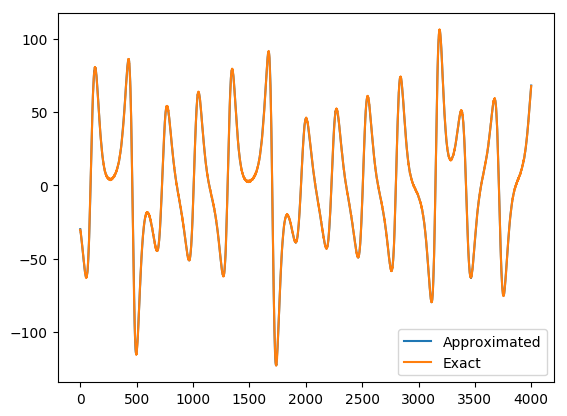

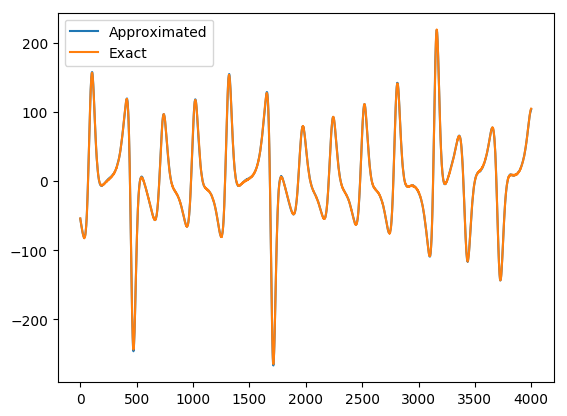

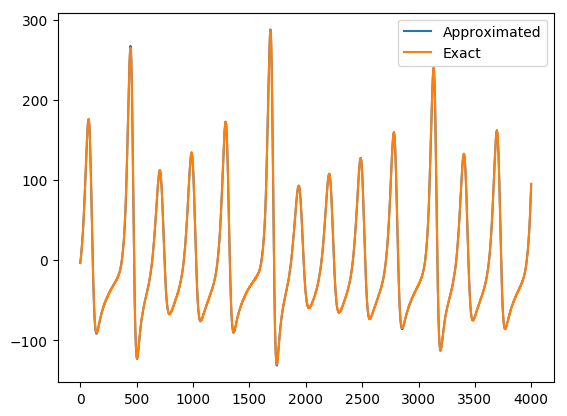

Approximation error for the derivatives: 0.8688030894575739 %


In [19]:
approximated_data = lorenz_net.eval(trunk_data=test_input_data, branch_data=test_forcing_data)

l2_norm = L2Norm()

error = 100*l2_norm(data=approximated_data, reference_data=test_output_data, relative_norm=True)

for ii in range(n_inputs):

    plt.plot(approximated_data[:, ii], label="Approximated")
    plt.plot(test_output_data[:, ii], label="Exact")
    plt.legend()
    plt.show()

print(f"Approximation error for the derivatives: {error} %")